# Fastai2 Variational AutoEncoder

Inspired by:
- _Hands on machine learning with scikit-learn, keras and tensorflow, Aurélien Géron_ 2nd ed, Chapter 17
- _The keras blog_ https://blog.keras.io/building-autoencoders-in-keras.html
- _GANs in Action_ https://github.com/GANs-in-Action/gans-in-action/blob/master/chapter-2/Chapter_2_Autoencoder.ipynb

In [1]:
%matplotlib inline

In [2]:
from fastai2.vision.all import *
from nbdev.showdoc import *

set_seed(2)

In [3]:
path = untar_data(URLs.MNIST); path

Path('/Users/jeremyblythe/.fastai/data/mnist_png')

In [4]:
mnist = DataBlock(blocks = (ImageBlock(cls=PILImageBW),ImageBlock(cls=PILImageBW)),
                  get_items = get_image_files,
                  splitter = GrandparentSplitter(train_name='training', valid_name='testing') )

In [5]:
data = mnist.dataloaders(path)

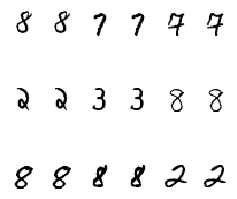

In [6]:
data.show_batch(figsize=(4,4))

In [63]:
# define the NN architecture
class VaeEncoder(nn.Module):
    def __init__(self):
        super(VaeEncoder, self).__init__()
        ## encoder ##
        self.fc1 = nn.Linear(28 * 28, intermediate_dim)
        # defining the mean of the latent space
        self.fc_mean = nn.Linear(intermediate_dim, latent_dim)
        # defining the log variance of the latent space
        self.fc_log_var = nn.Linear(intermediate_dim, latent_dim)
        
    def sampling(self, z_mean, z_log_var):
        epsilon = torch.randn(z_mean.shape[0], latent_dim)
        return z_mean + torch.exp(z_log_var / 2) * epsilon
    
    def forward(self, x):
        # flatten images
        x = x.view(x.size(0), -1)
        h = F.relu(self.fc1(x))
        z_mean = self.fc_mean(h)
        z_log_var = self.fc_log_var(h)
        z = self.sampling(z_mean, z_log_var)
        return z, z_mean, z_log_var
    
class VaeDecoder(nn.Module):
    def __init__(self):
        super(VaeDecoder, self).__init__()
        # linear layer (encoding_dim -> input size)
        self.fc2 = nn.Linear(latent_dim, intermediate_dim)
        self.fc3 = nn.Linear(intermediate_dim, 28 * 28)
            
    def forward(self, z):
        decoder_h = F.relu(self.fc2(z))
        # output layer (sigmoid for scaling from 0 to 1)
        x_decoded = F.sigmoid(self.fc3(decoder_h))
        #print(x.shape)
        # reshape to 28x28
        x_out = x_decoded.view(x_decoded.size(0), 1, 28, 28)
        #print(x.shape)
        return x_out

class Vae(nn.Module):
    def __init__(self):
        super(Vae, self).__init__()
        self.encoder = VaeEncoder()
        self.decoder = VaeDecoder()
            
    def forward(self, x):
        x,m,v = self.encoder(x)
        x = self.decoder(x)
        return x,m,v    
    
# initialize the NN
intermediate_dim = 256
latent_dim = 2
model = Vae()
print(model)

Vae(
  (encoder): VaeEncoder(
    (fc1): Linear(in_features=784, out_features=256, bias=True)
    (fc_mean): Linear(in_features=256, out_features=2, bias=True)
    (fc_log_var): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): VaeDecoder(
    (fc2): Linear(in_features=2, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=784, bias=True)
  )
)


In [166]:
class LossFunc(nn.Module):
    def __init__(self):
        super(LossFunc, self).__init__()
        return

    def forward(self, pred, target):
        x, z_mean, z_log_var=pred
        mse_loss = nn.MSELoss()(x,target)
        kl_loss = - 0.5 * torch.sum(1 + z_log_var - z_mean**2 - torch.exp(z_log_var), 1)
        # KL (latent) loss scaled to match mse (reconstruction) loss
        vae_loss = torch.mean(kl_loss) / 784 + mse_loss 
        return vae_loss

In [167]:
learn = Learner(data, model, loss_func=LossFunc())

In [168]:
learn.summary()

Vae (Input shape: ['64 x 1 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Linear               64 x 256             200,960    True      
________________________________________________________________
Linear               64 x 2               514        True      
________________________________________________________________
Linear               64 x 2               514        True      
________________________________________________________________
Linear               64 x 256             768        True      
________________________________________________________________
Linear               64 x 784             201,488    True      
________________________________________________________________

Total params: 404,244
Total trainable params: 404,244
Total non-trainable params: 0

Optimizer used: <function Adam at 0x12ae620d0>
Loss function: LossFunc()

Callbacks:
  - TrainEvalCallback
  - Recorder
  - ProgressCallback

In [169]:
learn.fit(100)

epoch,train_loss,valid_loss,time
0,0.046629,0.047425,00:39
1,0.046414,0.047494,00:47
2,0.046498,0.047428,00:46
3,0.046211,0.047352,00:43
4,0.046166,0.047214,00:39
5,0.046231,0.047420,00:41
6,0.045948,0.047290,00:43
7,0.046092,0.047273,00:38
8,0.046164,0.047189,00:43
9,0.046036,0.047259,00:47


In [170]:
def show_results(ds_idx=1, dl=None, max_n=9, shuffle=True, **kwargs):
    if dl is None: dl = learn.dls[ds_idx].new(shuffle=shuffle)
    b = dl.one_batch()
    _,_,preds = learn.get_preds(dl=[b], with_decoded=True)
    learn.dls.show_results(b, preds[0], max_n=max_n, **kwargs)

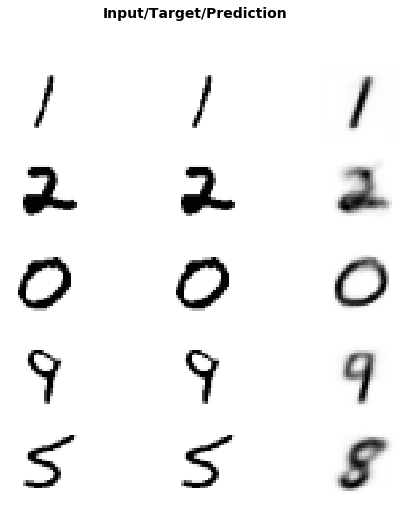

In [171]:
show_results(max_n=6, figsize=(8,8))

In [172]:
mnist_test = DataBlock(blocks = (ImageBlock(cls=PILImageBW),CategoryBlock),
                  get_items = get_image_files,
                  splitter = GrandparentSplitter(train_name='training', valid_name='testing'),
                get_y=parent_label)

data_test = mnist_test.dataloaders(path, bs=5000)

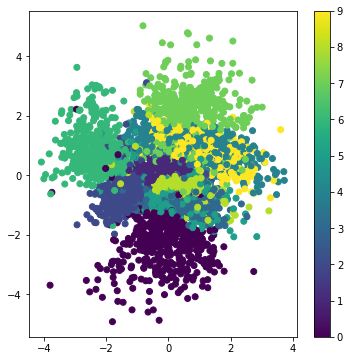

In [173]:
x_test, y_test = data_test.one_batch()
x_test_encoded,_,_ = model.encoder(x_test)
x_test_encoded = x_test_encoded.detach().numpy()
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test.detach().numpy(), cmap='viridis')
plt.colorbar()
plt.show()

In [174]:
from scipy.stats import norm

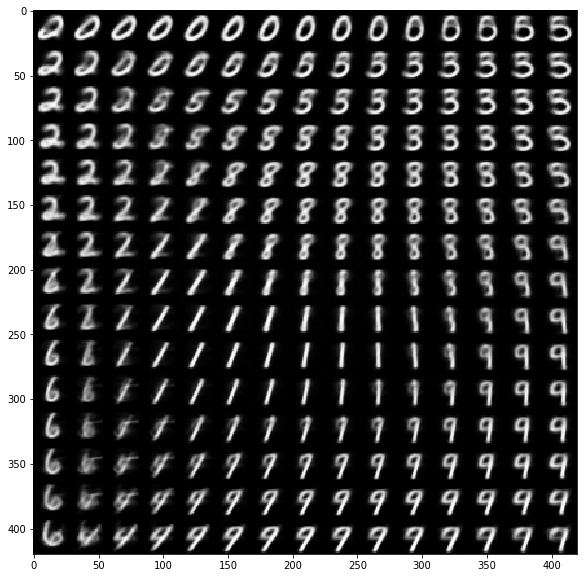

In [175]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = torch.Tensor([[xi, yi]])
        x_decoded = model.decoder(z_sample).detach().numpy()
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()